In [1]:
import coinbase_client
import pandas as pd

c:\Users\Brian\_projects\backtest_notebook\venv\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
c:\Users\Brian\_projects\backtest_notebook\venv\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
candles = coinbase_client.get_price_history('BTC-USD', bars=1800, granularity='ONE_DAY')
gap_table, gap_fill_table = coinbase_client.build_weekend_gap_tables(candles)
candles

c:\Users\Brian\_projects\backtest_notebook\notes\crypto_gap_research\coinbase_client.py:180: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  price_data['start'] = pd.to_datetime(price_data['start'], unit='s')
c:\Users\Brian\_projects\backtest_notebook\notes\crypto_gap_research\coinbase_client.py:180: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  price_data['start'] = pd.to_datetime(price_data['start'], unit='s')
c:\Users\Brian\_projects\backtest_notebook\notes\crypto_gap_research\coi

,start,low,high,open,close,volume,day_of_week
0,2015-09-17,229.01,235.93,229.72,233.34,7527.998306,3
1,2015-09-18,231.75,234.96,233.31,233.78,4688.450795,4
2,2015-09-19,232.00,234.31,233.78,232.88,3604.571903,5
3,2015-09-20,231.84,234.00,232.88,232.24,3683.553989,6
4,2015-09-21,226.87,233.64,232.26,227.31,7599.804816,0
...,...,...,...,...,...,...,...
1800,2024-09-24,62689.15,64700.00,63338.85,64272.93,8933.464736,1
1801,2024-09-25,62932.80,64811.00,64272.93,63130.89,5909.095105,2
1802,2024-09-26,62652.99,65865.00,63131.13,65177.21,12789.850355,3
1803,2024-09-27,64827.85,66550.00,65176.39,65789.00,9529.016881,4


In [3]:

# BEGIN: Set dtype of columns in candles table

# END: Set dtype of columns in candles table
candles.info(), gap_table.info(), gap_fill_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 0 to 1804
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   start        1805 non-null   datetime64[ns]
 1   low          1805 non-null   float64       
 2   high         1805 non-null   float64       
 3   open         1805 non-null   float64       
 4   close        1805 non-null   float64       
 5   volume       1805 non-null   float64       
 6   day_of_week  1805 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(1)
memory usage: 91.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gap_start_date  257 non-null    int64 
 1   gap_end_date    257 non-null    int64 
 2   gap_type        257 non-null    object
dtypes: int64(2), object(1)
memory usage: 6.2+ KB
<class 'p

(None, None, None)

In [4]:
import pandas as pd
import numpy as np

# Reset index on gap_table to make 'id' a column
gap_table_reset = gap_table.reset_index()

# Perform a left join between gap_table_reset and gap_fill on 'id' (now a column) and 'gap_id'
gap_with_fills = pd.merge(gap_table_reset, gap_fill_table, left_on='index', right_on='gap_id', how='right')

# Drop the redundant 'gap_id' column if needed
gap_with_fills.drop(columns=['gap_id'], inplace=True)

def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

def calculate_volatility(prices, window=20):
    """
    Calculate the volatility of price movements.

    :param prices: A pandas Series of prices.
    :param window: The rolling window size for volatility calculation.
    :return: A pandas Series of volatility values.
    """
    # Calculate logarithmic returns
    log_returns = np.log(prices / prices.shift(1))
    
    # Calculate rolling standard deviation of log returns
    volatility = log_returns.rolling(window=window).std()
    
    return volatility

def calculate_atr(high, low, close, window=14):
    """
    Calculate the Average True Range (ATR).

    :param high: A pandas Series of high prices.
    :param low: A pandas Series of low prices.
    :param close: A pandas Series of close prices.
    :param window: The rolling window size for ATR calculation.
    :return: A pandas Series of ATR values.
    """
    # Calculate the True Range (TR)
    tr1 = high - low
    tr2 = np.abs(high - close.shift(1))
    tr3 = np.abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Calculate the ATR
    atr = tr.rolling(window=window).mean()
    
    return atr

def calculate_atr_std(atr, window=14):
    """
    Calculate the standard deviation of ATR.

    :param atr: A pandas Series of ATR values.
    :param window: The rolling window size for standard deviation calculation.
    :return: A pandas Series of ATR standard deviation values.
    """
    atr_std = atr.rolling(window=window).std()
    return atr_std

candles['atr_std'] = atr(candles).rolling(window=14).std()

# Display the result
gap_with_fills.head()

candles.tail()


,start,low,high,open,close,volume,day_of_week,atr_std
1800,2024-09-24,62689.15,64700.00,63338.85,64272.93,8933.464736,1,104.373182
1801,2024-09-25,62932.80,64811.00,64272.93,63130.89,5909.095105,2,102.264171
1802,2024-09-26,62652.99,65865.00,63131.13,65177.21,12789.850355,3,99.309942
1803,2024-09-27,64827.85,66550.00,65176.39,65789.00,9529.016881,4,90.619202
1804,2024-09-28,65432.10,66266.39,65787.53,65803.41,2002.767515,5,98.443094


<Axes: title={'center': 'Histogram of gap fill lag in days for down gaps'}, ylabel='Frequency'>

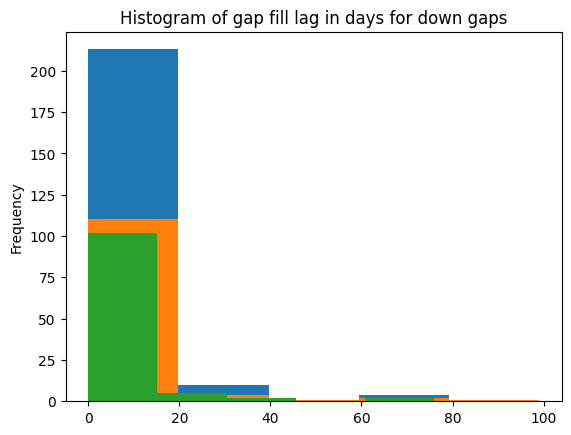

In [5]:
gap_with_fills['lag'] = gap_with_fills.gap_fill_date - gap_with_fills.gap_end_date
bins = 5
g = gap_with_fills.loc[gap_with_fills.lag < 100].copy()
g.lag.plot(kind='hist', bins=bins, title='Histogram of gap fill lag in days')
g.loc[g.gap_type == 'up', 'lag'].plot(kind='hist', bins=bins, title='Histogram of gap fill lag in days for up gaps')
g.loc[g.gap_type == 'down', 'lag'].plot(kind='hist', bins=bins, title='Histogram of gap fill lag in days for down gaps')

In [6]:
candles.reset_index()


,index,start,low,high,open,close,volume,day_of_week,atr_std
0,0,2015-09-17,229.01,235.93,229.72,233.34,7527.998306,3,NaN
1,1,2015-09-18,231.75,234.96,233.31,233.78,4688.450795,4,NaN
2,2,2015-09-19,232.00,234.31,233.78,232.88,3604.571903,5,NaN
3,3,2015-09-20,231.84,234.00,232.88,232.24,3683.553989,6,NaN
4,4,2015-09-21,226.87,233.64,232.26,227.31,7599.804816,0,NaN
...,...,...,...,...,...,...,...,...,...
1800,1800,2024-09-24,62689.15,64700.00,63338.85,64272.93,8933.464736,1,104.373182
1801,1801,2024-09-25,62932.80,64811.00,64272.93,63130.89,5909.095105,2,102.264171
1802,1802,2024-09-26,62652.99,65865.00,63131.13,65177.21,12789.850355,3,99.309942
1803,1803,2024-09-27,64827.85,66550.00,65176.39,65789.00,9529.016881,4,90.619202


In [7]:
gap_with_fills['gap_start_price'] = gap_with_fills.apply(lambda x: candles.loc[x.gap_start_date, 'close'], axis=1)
gap_with_fills['gap_end_price'] = gap_with_fills.apply(lambda x: candles.loc[x.gap_end_date, 'open'], axis=1)
gap_with_fills['start'] = gap_with_fills.apply(lambda x: candles.loc[x.gap_start_date, 'start'], axis=1)
gap_with_fills['atr_std'] = gap_with_fills.apply(lambda x: candles.loc[x.gap_start_date, 'atr_std'], axis=1)

In [8]:
gap_with_fills['gap_diff'] = np.log(gap_with_fills.gap_end_price / gap_with_fills.gap_start_price)


<Axes: title={'center': 'Scatter plot of gap fill lag vs gap diff'}, xlabel='gap_diff', ylabel='lag'>

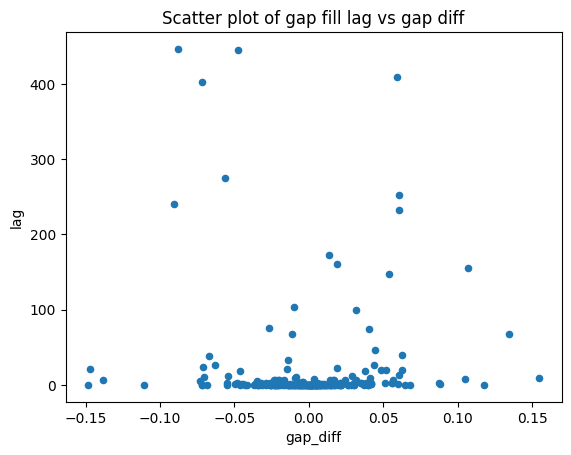

In [9]:
gap_with_fills[['gap_diff', 'lag']].loc[gap_with_fills.gap_diff > -0.2].plot(kind='scatter', x='gap_diff', y='lag', title='Scatter plot of gap fill lag vs gap diff')

<Axes: title={'center': 'Close price and ATR with close price at lag'}>

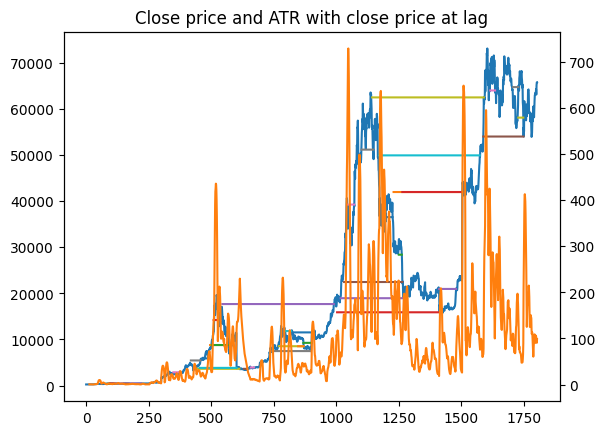

In [10]:
# gap_with_fills.loc[abs(gap_with_fills.gap_diff) > 1000].copy()
# for i, row in gap_with_fills.iterrows():
#     abs_high_max = candles.loc[row.gap_start_date:row.gap_end_date, 'high'].max()

gap_with_fills['close_at_lag'] = gap_with_fills.apply(
    lambda x: candles.loc[x.gap_end_date:x.gap_end_date + x.lag, 'close'].values[-1], axis=1
)
close_at_lag_cols = []
for i, row in gap_with_fills.loc[gap_with_fills.lag > 10].iterrows():
    close_at_lag_col = f'close_at_lag{i}'
    close_at_lag_cols.append(close_at_lag_col)
    candles.loc[row.gap_end_date:(row.gap_end_date + row.lag), close_at_lag_col] = row.close_at_lag

candles[['close', 'atr_std']+close_at_lag_cols].plot(legend=False, secondary_y='atr_std', title='Close price and ATR with close price at lag')

<Axes: title={'center': 'Scatter plot of gap fill lag vs ATR std'}, xlabel='lag', ylabel='atr_std'>

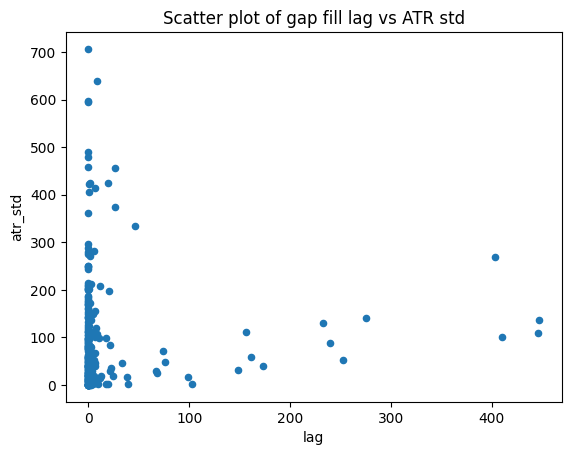

In [11]:
gap_with_fills[['lag', 'atr_std']].plot(kind='scatter', x='lag', y='atr_std', title='Scatter plot of gap fill lag vs ATR std')

# TODO 
#   assuming a strategy of mean reversion back to the friday gap price,
#   calculate the expanding risk of the trad as the gap fill lag increases.
#   There seems to be tail risk regardless gap size. Can we limit it by
#   setting a timed stop if fill doesn't occure in 1-2 weeks?
#   - does waiting too long increase the size of potential losses
#       - to get a sense of theoretical losses:
#           - for gap ups, get the max price between gap_end and lag dates
#           - get min of gap downs 
#   - can we descover a logical stop loss to maintain a positive edge?

c:\Users\Brian\_projects\backtest_notebook\notes\crypto_gap_research\coinbase_client.py:180: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  price_data['start'] = pd.to_datetime(price_data['start'], unit='s')


<Axes: xlabel='start'>

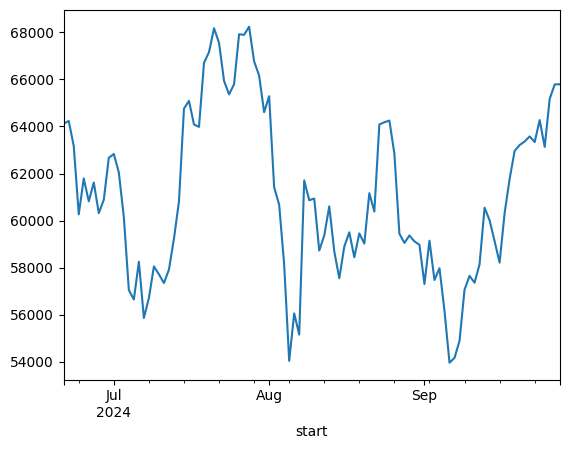

In [12]:
# Filter candles DataFrame for 5pm close prices
candles_15m = coinbase_client.get_price_history('BTC-USD', bars=100, granularity='ONE_DAY')
candles_15m = candles_15m.set_index('start')
candles_15m.close.plot()

In [13]:
candles_15m.tail()

,low,high,open,close,volume
start,,,,,
2024-09-24,62689.15,64700.00,63338.85,64272.93,8933.464736
2024-09-25,62932.80,64811.00,64272.93,63130.89,5909.095105
2024-09-26,62652.99,65865.00,63131.13,65177.21,12789.850355
2024-09-27,64827.85,66550.00,65176.39,65789.00,9529.016881
2024-09-28,65432.10,66266.39,65787.53,65798.04,2002.824599


In [14]:
# Select data from the most recent Friday onward
most_recent_friday = candles_15m.loc[
    (candles_15m.index.dayofweek == 4) 
    # & (candles_15m['start'].dt.hour == 16) 
    # & (candles_15m['start'].dt.minute >= 40)
].iloc[-1]
# candles_15m_recent_friday = candles_15m[candles_15m['start'] >= most_recent_friday]
# candles_15m_recent_friday.head()

most_recent_friday

low       64827.850000
high      66550.000000
open      65176.390000
close     65789.000000
volume     9529.016881
Name: 2024-09-27 00:00:00, dtype: float64

In [15]:
portfolio_id = coinbase_client.client.get_portfolios()['portfolios'][0]['uuid']
portfolio = coinbase_client.client.get_portfolio_breakdown(portfolio_id, currency='USD')
"""
{'breakdown': {'portfolio': {'name': 'Default',
   'uuid': 'c6178073-3d59-5f24-8d75-2df8c3d375c8',
   'type': 'DEFAULT',
   'deleted': False},
  'portfolio_balances': {'total_balance': {'value': '2619.43',
"""
portfolio_balance = float(portfolio['breakdown']['portfolio_balances']['total_balance']['value'])
print('Portfolio balance:', portfolio_balance)
close = most_recent_friday.close
# 1.5, 3.0, 5.0, 7.5... thru 20%

percents = [1.5, 3.0, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]
trade_size = .01 * portfolio_balance
"""
def limit_order_gtc_buy(
    self,
    client_order_id: str,
    product_id: str,
    base_size: str,
    limit_price: str,
    post_only: bool = False,
    self_trade_prevention_id: Optional[str] = None,
    leverage: Optional[str] = None,
    margin_type: Optional[str] = None,
    retail_portfolio_id: Optional[str] = None,
    **kwargs,
) -> Dict[str, Any]:
"""
for percent in percents:
    limit_price = round(close * (1 - percent / 100), 2) # buy side limit price
    quantity = round(trade_size / limit_price, 8)
    resp = coinbase_client.client.limit_order_gtc_buy(
        client_order_id='',
        product_id='BTC-USD',
        base_size=str(quantity),
        limit_price=str(limit_price)
    )
    print(resp)

    # TODO create limit orders (check if they already exist first)




Portfolio balance: 2661.68
{'success': True, 'success_response': {'order_id': '9561805b-4edf-4dab-86ef-af18448c7aa3', 'product_id': 'BTC-USD', 'side': 'BUY', 'client_order_id': 'b405d2f2c72943e8b310bd6483af6114', 'attached_order_id': ''}, 'order_configuration': {'limit_limit_gtc': {'base_size': '0.00041074', 'limit_price': '64802.16', 'post_only': False}}}
{'success': True, 'success_response': {'order_id': 'f4415a3b-8571-46e4-b2e1-c4fca4a54198', 'product_id': 'BTC-USD', 'side': 'BUY', 'client_order_id': '6d4b9cc878ea482a94f6c92b2bd7e6eb', 'attached_order_id': ''}, 'order_configuration': {'limit_limit_gtc': {'base_size': '0.00041709', 'limit_price': '63815.33', 'post_only': False}}}
{'success': True, 'success_response': {'order_id': '93c33e67-9287-4fa6-8409-40544027c353', 'product_id': 'BTC-USD', 'side': 'BUY', 'client_order_id': '2ab18253a0114fa29683051856b511b0', 'attached_order_id': ''}, 'order_configuration': {'limit_limit_gtc': {'base_size': '0.00042587', 'limit_price': '62499.55',

In [16]:
from pprint import pprint
account_table = pd.DataFrame(coinbase_client.client.get_accounts()['accounts'])
account_table['value'] = pd.json_normalize(account_table.available_balance)['value']
account_table

,uuid,name,currency,available_balance,default,active,created_at,updated_at,deleted_at,type,ready,hold,retail_portfolio_id,value
0,3f337721-7d12-54c8-a2a1-823f53e09124,USDC Wallet,USDC,"{'value': '1005.21059', 'currency': 'USDC'}",True,True,2024-03-19T20:16:48.591Z,2024-09-07T05:58:25.161Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'USDC'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,1005.21059
1,ad90142c-1bb7-567f-a72f-2394bcf33850,ALGO Wallet,ALGO,"{'value': '0', 'currency': 'ALGO'}",True,True,2021-08-21T19:48:41.243Z,2021-08-21T19:48:41.243Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ALGO'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
2,f0de125d-b70b-5782-b5e7-a44d23dfc303,ZEC Wallet,ZEC,"{'value': '0', 'currency': 'ZEC'}",True,True,2021-08-10T22:06:42.250Z,2021-08-10T22:06:42.384Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ZEC'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
3,430cd5c9-6727-56c2-af79-3105624f4de4,ETC Wallet,ETC,"{'value': '0', 'currency': 'ETC'}",True,True,2021-06-21T16:49:32.530Z,2021-06-21T16:49:32.530Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ETC'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
4,99e94d52-33ad-58a9-8832-2bddd7b8a9cd,ZRX Wallet,ZRX,"{'value': '0', 'currency': 'ZRX'}",True,True,2021-06-21T16:49:32.041Z,2021-06-21T16:49:32.267Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ZRX'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
5,f8b2dd59-826a-5388-9fb6-44ef6f98a0a6,ETH Wallet,ETH,"{'value': '0', 'currency': 'ETH'}",True,True,2021-06-20T02:23:58.606Z,2024-08-07T23:22:45.552Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ETH'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
6,a3e14038-9169-5d91-abe8-da3e59dd4d05,ADA Wallet,ADA,"{'value': '0', 'currency': 'ADA'}",True,True,2021-06-20T02:21:35.250Z,2024-08-07T23:20:13.406Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'ADA'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0
7,31b0fc20-dd46-51e8-bebf-edf75f481de0,Cash (USD),USD,"{'value': '92.2061237773866', 'currency': 'USD'}",False,True,2021-06-19T03:31:53.668Z,2024-09-23T13:10:22.239Z,None,ACCOUNT_TYPE_FIAT,True,"{'value': '242.4254599855572', 'currency': 'USD'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,92.2061237773866
8,33d231b3-25e8-5403-94e6-ee0f1831ff14,BTC Wallet,BTC,"{'value': '0.0162718182183481', 'currency': 'B...",True,True,2021-06-19T02:52:03.202Z,2024-09-23T13:10:22.290Z,None,ACCOUNT_TYPE_CRYPTO,True,"{'value': '0', 'currency': 'BTC'}",c6178073-3d59-5f24-8d75-2df8c3d375c8,0.0162718182183481
